# Image Classification on Food 101 (10% of the data)

## Table of contents

1. [Check system resourses](#check-system-resourses) 
2. [Downloading and preprocessing the data](#downloading-and-preprocessing-the-data)

# Model Expirements
* change the global avarage layer to global maximum layer
* add dropout layer 

## Check system resourses

In [26]:
# remove system logs
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" # or any {"0", "1", "2"}

In [1]:
!nvidia-smi -L

/bin/bash: /root/miniconda3/envs/tf2/lib/libtinfo.so.6: no version information available (required by /bin/bash)
GPU 0: NVIDIA GeForce RTX 3070 (UUID: GPU-17663cf8-e59a-a0ea-7337-d7a8097f2cae)


In [5]:
import sys
sys.path.append('../')
from scripts.helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## Downloading and preprocessing the data

In [33]:

# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip -P ../data/Food_vision_10_percent/

/bin/bash: /root/miniconda3/envs/tf2/lib/libtinfo.so.6: no version information available (required by /bin/bash)
--2023-11-10 17:34:29--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.22.59, 172.217.22.27, 142.251.37.91, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.22.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘../data/Food_vision_10_percent/101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  18.0MB/s    in 81s     

2023-11-10 17:35:50 (19.2 MB/s) - ‘../data/Food_vision_10_percent/101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [31]:
data_dir = "../data/Food_vision_10_percent/"
file_name = "101_food_classes_10_percent.zip"

In [34]:

unzip_data(data_dir + file_name, work_dir=False)


In [6]:

train_dir = data_dir + "101_food_classes_10_percent/train/"
test_dir = data_dir + "101_food_classes_10_percent/test/"

In [7]:
# How many images/classes are there?
walk_through_dir("../data/Food_vision_10_percent/101_food_classes_10_percent")

There are 2 directories and 0 images in '/mnt/d/DATA/Food_vision_10_percent/101_food_classes_10_percent'.
There are 101 directories and 0 images in '/mnt/d/DATA/Food_vision_10_percent/101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '/mnt/d/DATA/Food_vision_10_percent/101_food_classes_10_percent/test/apple_pie'.
There are 0 directories and 250 images in '/mnt/d/DATA/Food_vision_10_percent/101_food_classes_10_percent/test/baby_back_ribs'.
There are 0 directories and 250 images in '/mnt/d/DATA/Food_vision_10_percent/101_food_classes_10_percent/test/baklava'.
There are 0 directories and 250 images in '/mnt/d/DATA/Food_vision_10_percent/101_food_classes_10_percent/test/beef_carpaccio'.
There are 0 directories and 250 images in '/mnt/d/DATA/Food_vision_10_percent/101_food_classes_10_percent/test/beef_tartare'.
There are 0 directories and 250 images in '/mnt/d/DATA/Food_vision_10_percent/101_food_classes_10_percent/test/beet_salad'.
There are 0 directories and 250

In [8]:
print(f"{train_dir=}")
print(f"{test_dir=}")

train_dir='/mnt/d/DATA/Food_vision_10_percent/101_food_classes_10_percent/train/'
test_dir='/mnt/d/DATA/Food_vision_10_percent/101_food_classes_10_percent/test/'


In [9]:
data_dir = "../data/Food_vision_10_percent/"
train_dir = data_dir + "101_food_classes_10_percent/train/"
test_dir = data_dir + "101_food_classes_10_percent/test/"

# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction 

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Callbacks

In [10]:
# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "101_classes_10_percent_data_model_checkpoint/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=1) # don't print out whether or not model is being saved

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [11]:
tf.keras.mixed_precision.set_global_policy(policy="mixed_float16")
tf.keras.mixed_precision.global_policy()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070, compute capability 8.6


<Policy "mixed_float16">

## data augmentation

In [12]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

# Model 1

In [13]:
# Create base model
INPUT_SHAPE = (224, 224, 3)


# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = tf.keras.layers.Input(shape=INPUT_SHAPE, name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
#x = tf.keras.layers.Dense(128, activation="relu")(x)
#x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(len(train_data_all_10_percent.class_names))(x)
outputs = tf.keras.layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model = tf.keras.Model(inputs, outputs)

In [14]:
# Get a summary of our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                             

In [15]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.legacy.Adam(),
              metrics=["accuracy"])

In [16]:

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=20, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.3 * len(test_data)), # evaluate on smaller portion of test data
                                           callbacks=[model_checkpoint, early_stopping_callback]) # save best model weights to file

Epoch 1/20
237/237 [==============================] - ETA: 0s - loss: 3.6447 - accuracy: 0.1846
Epoch 1: val_accuracy improved from -inf to 0.36392, saving model to 101_classes_10_percent_data_model_checkpoint/cp.ckpt
237/237 [==============================] - 107s 384ms/step - loss: 3.6447 - accuracy: 0.1846 - val_loss: 2.5794 - val_accuracy: 0.3639
Epoch 2/20
237/237 [==============================] - ETA: 0s - loss: 2.4908 - accuracy: 0.3819
Epoch 2: val_accuracy improved from 0.36392 to 0.46084, saving model to 101_classes_10_percent_data_model_checkpoint/cp.ckpt
237/237 [==============================] - 74s 308ms/step - loss: 2.4908 - accuracy: 0.3819 - val_loss: 2.1107 - val_accuracy: 0.4608
Epoch 3/20
237/237 [==============================] - ETA: 0s - loss: 2.1063 - accuracy: 0.4519
Epoch 3: val_accuracy improved from 0.46084 to 0.50857, saving model to 101_classes_10_percent_data_model_checkpoint/cp.ckpt
237/237 [==============================] - 67s 279ms/step - loss: 2.106

## Model 1 Evaluation

In [17]:
# Evaluate model 
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 54s 68ms/step - loss: 1.6093 - accuracy: 0.5683


[1.6092721223831177, 0.5683168172836304]

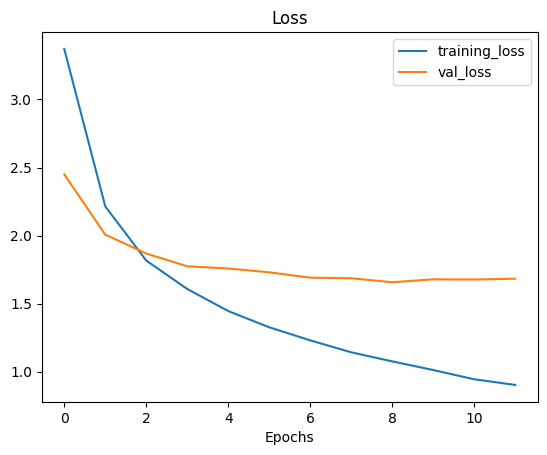

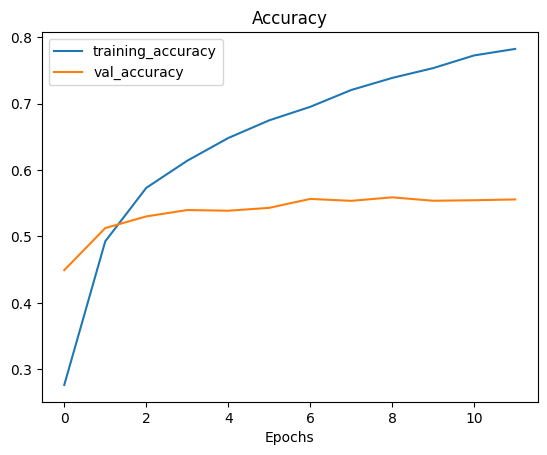

In [17]:
plot_loss_curves(history_all_classes_10_percent)

# Model 2
change the base model to efficientnet_V2

In [24]:
# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "101_classes_10_percent_data_model_2_checkpoint/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=1) # don't print out whether or not model is being saved

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [27]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = tf.keras.layers.Input(shape=INPUT_SHAPE, name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
x = tf.keras.layers.Dense(len(train_data_all_10_percent.class_names))(x)
outputs = tf.keras.layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model_2 = tf.keras.Model(inputs, outputs)

In [28]:
model_2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling (Gl  (None, 1536)              0         
 obalAveragePooling2D)                                           
                                                                 
 dense_3 (Dense)             (None, 101)               155237    
                                                           

In [29]:
# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.legacy.Adam(),
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent_model_2 = model_2.fit(train_data_all_10_percent,
                                                     epochs=20, # fit for 5 epochs to keep experiments quick
                                                     validation_data=test_data,
                                                     validation_steps=int(0.3 * len(test_data)), # evaluate on smaller portion of test data
                                                     callbacks=[model_checkpoint, early_stopping_callback]) # save best model weights to file

Epoch 1/20


237/237 [==============================] - ETA: 0s - loss: 3.3897 - accuracy: 0.2646
Epoch 1: val_accuracy improved from -inf to 0.41324, saving model to 101_classes_10_percent_data_model_2_checkpoint/cp.ckpt
237/237 [==============================] - 116s 425ms/step - loss: 3.3897 - accuracy: 0.2646 - val_loss: 2.4252 - val_accuracy: 0.4132
Epoch 2/20
237/237 [==============================] - ETA: 0s - loss: 2.3107 - accuracy: 0.4632
Epoch 2: val_accuracy improved from 0.41324 to 0.47073, saving model to 101_classes_10_percent_data_model_2_checkpoint/cp.ckpt
237/237 [==============================] - 88s 370ms/step - loss: 2.3107 - accuracy: 0.4632 - val_loss: 2.0496 - val_accuracy: 0.4707
Epoch 3/20
237/237 [==============================] - ETA: 0s - loss: 1.9530 - accuracy: 0.5232
Epoch 3: val_accuracy improved from 0.47073 to 0.50804, saving model to 101_classes_10_percent_data_model_2_checkpoint/cp.ckpt
237/237 [==============================] - 83s 346ms/step - loss: 1.9530 - a

## Model 2 - Evaluation

In [32]:
# Evaluate model 
results_feature_extraction_model_2 = model_2.evaluate(test_data)
results_feature_extraction_model_2

790/790 [==============================] - 55s 70ms/step - loss: 1.5145 - accuracy: 0.5944


[1.5144678354263306, 0.5944158434867859]

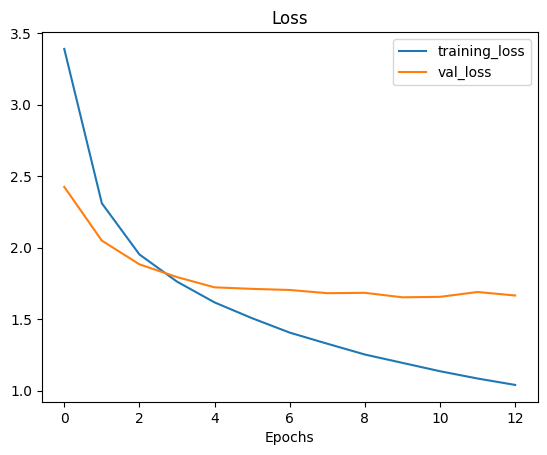

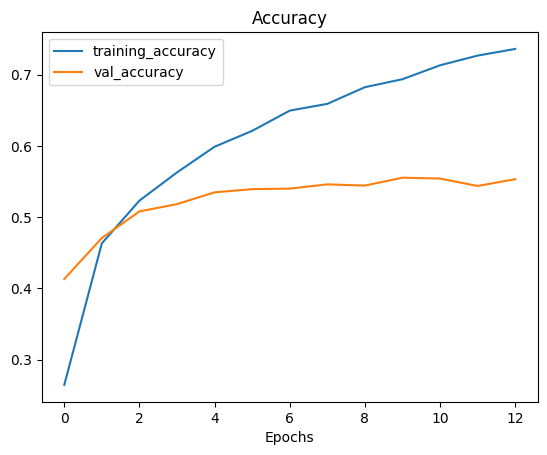

In [33]:
plot_loss_curves(history_all_classes_10_percent_model_2)

# Model 3
global maximum layer

In [34]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = tf.keras.layers.Input(shape=INPUT_SHAPE, name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
#x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
x = tf.keras.layers.GlobalMaxPooling2D(name="global_max_pooling")(x)
x = tf.keras.layers.Dense(len(train_data_all_10_percent.class_names))(x)
outputs = tf.keras.layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model_3 = tf.keras.Model(inputs, outputs)

In [35]:
model_3.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_max_pooling (Global  (None, 1536)              0         
 MaxPooling2D)                                                   
                                                                 
 dense_4 (Dense)             (None, 101)               155237    
                                                           

In [40]:
# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "101_classes_10_percent_data_model_3_checkpoint/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=1) # don't print out whether or not model is being saved

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [41]:
# Compile
model_3.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.legacy.Adam(),
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent_model_2 = model_3.fit(train_data_all_10_percent,
                                                     epochs=20, # fit for 5 epochs to keep experiments quick
                                                     validation_data=test_data,
                                                     validation_steps=int(0.3 * len(test_data)), # evaluate on smaller portion of test data
                                                     callbacks=[model_checkpoint, early_stopping_callback]) # save best model weights to file

Epoch 1/20
237/237 [==============================] - ETA: 0s - loss: 5.3423 - accuracy: 0.1360
Epoch 1: val_accuracy improved from -inf to 0.25514, saving model to 101_classes_10_percent_data_model_3_checkpoint/cp.ckpt
237/237 [==============================] - 74s 247ms/step - loss: 5.3423 - accuracy: 0.1360 - val_loss: 3.7666 - val_accuracy: 0.2551
Epoch 2/20
237/237 [==============================] - ETA: 0s - loss: 3.4822 - accuracy: 0.3038
Epoch 2: val_accuracy improved from 0.25514 to 0.36076, saving model to 101_classes_10_percent_data_model_3_checkpoint/cp.ckpt
237/237 [==============================] - 55s 230ms/step - loss: 3.4822 - accuracy: 0.3038 - val_loss: 3.1907 - val_accuracy: 0.3608
Epoch 3/20
237/237 [==============================] - ETA: 0s - loss: 3.1025 - accuracy: 0.3702
Epoch 3: val_accuracy improved from 0.36076 to 0.40928, saving model to 101_classes_10_percent_data_model_3_checkpoint/cp.ckpt
237/237 [==============================] - 53s 224ms/step - loss: 

In [43]:
# Evaluate model 
results_feature_extraction_model_3 = model_3.evaluate(test_data)
results_feature_extraction_model_3

790/790 [==============================] - 55s 69ms/step - loss: 2.6332 - accuracy: 0.4912


[2.6332106590270996, 0.49120792746543884]

### Dropout layer - exp

In [2]:
# remove system logs
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" # or any {"0", "1", "2"}

In [7]:
tf.keras.mixed_precision.set_global_policy(policy="mixed_float16")
tf.keras.mixed_precision.global_policy()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070, compute capability 8.6


2023-08-22 19:31:09.204861: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.


<Policy "mixed_float16">

In [6]:

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

In [3]:

data_dir = "/mnt/d/DATA/Food_vision_10_percent/"
train_dir = data_dir + "101_food_classes_10_percent/train/"
test_dir = data_dir + "101_food_classes_10_percent/test/"

# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction 

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Model 4

In [8]:
INPUT_SHAPE = (224, 224, 3)

# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = tf.keras.layers.Input(shape=INPUT_SHAPE, name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
#x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_2D")(x)
x = tf.keras.layers.Dropout(0.2, name="dropout_layer")(x)
x = tf.keras.layers.Dense(len(train_data_all_10_percent.class_names))(x)
outputs = tf.keras.layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model_4 = tf.keras.Model(inputs, outputs)

In [9]:
# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "101_classes_10_percent_data_model_4_checkpoint/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=1) # don't print out whether or not model is being saved

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Compile
model_4.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.legacy.Adam(),
              metrics=["accuracy"])

In [10]:
# Fit
history_all_classes_10_percent_model_4 = model_4.fit(train_data_all_10_percent,
                                                     epochs=20, # fit for 5 epochs to keep experiments quick
                                                     validation_data=test_data,
                                                     validation_steps=int(0.3 * len(test_data)), # evaluate on smaller portion of test data
                                                     callbacks=[model_checkpoint, early_stopping_callback]) # save best model weights to file

Epoch 1/20


2023-08-22 19:32:42.371088: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


237/237 [==============================] - ETA: 0s - loss: 3.4642 - accuracy: 0.2389
Epoch 1: val_accuracy improved from -inf to 0.39425, saving model to 101_classes_10_percent_data_model_4_checkpoint/cp.ckpt
237/237 [==============================] - 168s 618ms/step - loss: 3.4642 - accuracy: 0.2389 - val_loss: 2.5109 - val_accuracy: 0.3943
Epoch 2/20
237/237 [==============================] - ETA: 0s - loss: 2.3947 - accuracy: 0.4329
Epoch 2: val_accuracy improved from 0.39425 to 0.46268, saving model to 101_classes_10_percent_data_model_4_checkpoint/cp.ckpt
237/237 [==============================] - 112s 468ms/step - loss: 2.3947 - accuracy: 0.4329 - val_loss: 2.0955 - val_accuracy: 0.4627
Epoch 3/20
237/237 [==============================] - ETA: 0s - loss: 2.0373 - accuracy: 0.5056
Epoch 3: val_accuracy improved from 0.46268 to 0.50514, saving model to 101_classes_10_percent_data_model_4_checkpoint/cp.ckpt
237/237 [==============================] - 99s 414ms/step - loss: 2.0373 - 

## Model 4 Evaluation

In [11]:
resualts_model_4 = model_4.evaluate(test_data)
resualts_model_4

790/790 [==============================] - 56s 71ms/step - loss: 1.5326 - accuracy: 0.5887


[1.5325636863708496, 0.5886732935905457]

## Model Comparison

| Model                 | Loss  | Accuracy  | Description                                               | Augmentation  | Trainable params  |
|-----------------------|:-----:|:---------:|-----------------------------------------------------------|:-------------:|:-----------------:|
| 1 - EfficientNetB0    | 1.609 | 0.568     | Basic model                                               | yes           | 176997            |
| 2 - EfficientNetV2B3  | 1.514 | 0.594     | Cahnge to EfficientNetV2B3                                | yes           | 155237            |
| 3 - Global layer      | 2.633 | 0.491     | Change the global avarage layer to global maximum layer   | yes           | 155237            |
| 4 - Dropout           | 1.532 | 0.588     | add dropout layer                                         | yes           | 155237            |